In [1]:
import sys
import glob
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

In [262]:
from torch.utils.data import Dataset, DataLoader
from torchdata.datapipes.iter import FileLister, FileOpener
from Src import PreprocessingPipeline

import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import os

In [24]:
prep_pipeline_func = PreprocessingPipeline(target_size=(224, 224, 3), is_gray=False)

In [25]:
BASE_PATH = '..\\'

ASSETS_PATH = os.path.join(BASE_PATH, 'Assets')
DATASET_PATH = os.path.join(ASSETS_PATH, 'Datasets', 'SIBI dataset')
TRAINING_PATH = os.path.join(DATASET_PATH, 'Train', '*', '*')


In [247]:
_class_paths = glob.glob(os.path.join(DATASET_PATH, 'Train', '*'))
CLASSES_LIST = sorted([os.path.basename(label) for label in _class_paths])

In [26]:
images_path_tf_data_train = tf.data.Dataset.list_files(TRAINING_PATH, shuffle=False)

In [6]:
for file in images_path_tf_data_train.take(1):
    split_text=tf.strings.split(file, sep=os.path.sep)
    for idx, value in enumerate(split_text):
        print(f"{idx} -> {value}")

0 -> b'..'
1 -> b'Assets'
2 -> b'Datasets'
3 -> b'SIBI dataset'
4 -> b'Train'
5 -> b'A'
6 -> b'image_A_(1723068076.1335173).jpg'


In [27]:
label_idx_from_path=5

images_tf_data_train = images_path_tf_data_train.map(
    map_func=lambda image_path: 
        prep_pipeline_func.convert_path_to_img_tf_data_train(
            image_path=image_path, 
            label_idx_from_path=label_idx_from_path,
        ),
    num_parallel_calls=tf.data.AUTOTUNE
)

images_tf_data_cached = images_tf_data_train.cache()

In [28]:
for image, label in images_tf_data_cached.skip(305).take(1):
    print(f"{'Check Train Data'.center(10, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    label: {label}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

Check Train Data
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.0

    label: b'B'
    label-shape: ()
    image-type: <dtype: 'string'>


In [248]:
images_tf_data_ohe = images_tf_data_cached.map(lambda image, label: prep_pipeline_func.one_hot_encode(image, label, CLASSES_LIST))
images_tf_data_ohe_cache = images_tf_data_ohe.cache()

In [249]:
# Print information about the cached dataset and the number of data points
print(f'info data: {images_tf_data_ohe_cache}')
print(f'number of data: {len(images_tf_data_ohe_cache)}')

info data: <CacheDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
number of data: 5200


In [250]:
# Menampilkan contoh data yang telah diubah
for image, label in images_tf_data_ohe_cache.skip(305).take(1):
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

=======================Check Train Data======================
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.0

    one-hot-label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    label-shape: (26,)
    image-type: <dtype: 'float32'>


In [307]:
class TFToTorchDataset(Dataset):
    def __init__(self, tf_dataset):
        self.tf_dataset = tf_dataset
        
    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        # Convert the index to a TensorFlow slice to efficiently get a single element
        for feature, label in self.tf_dataset.skip(idx).take(1):
            feature = torch.tensor(feature.numpy())
            label = torch.tensor(label.numpy())
            return feature, label
        raise IndexError

In [308]:
# Convert to PyTorch Dataset
torch_data = TFToTorchDataset(images_tf_data_ohe_cache)

In [309]:
len(torch_data)

5200

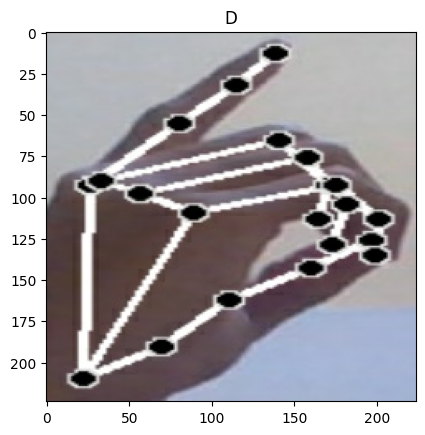

In [311]:
image, label = torch_data[600]
plt.imshow(image)
plt.title(CLASSES_LIST[label.argmax()])
plt.show()